In [234]:
from scipy.integrate import quad
from scipy.stats import chi2, binom, poisson, norm
from scipy.special import erfinv,erf
from scipy.optimize import minimize

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from iminuit import Minuit as im
import math

## Problem 1

In [235]:
claim_faulty_rate = 0.05 
true_faulty_rate = 0.15
N = 100 #sample size
t_cut = 9 # max faulty monitors

In [236]:
type1 = 1-np.sum(binom.pmf(np.arange(0,t_cut+1),N,claim_faulty_rate))
type1

0.028188294163416727

    Type I error for this case is ~ 2.8%.

In [237]:
type2 = np.sum(binom.pmf(np.arange(0,t_cut+1),N,true_faulty_rate))
type2

0.055094631692294414

    Type II for this case is ~ 5.5%

### Problem 2

In [238]:
"""
Required constants

The units of mass is changed to GeV/c**2
and unit of time is set to ps.

"""
mass_kaon = 0.4937
mass_pion = 0.1396

L = 20 #m
c = 3e+8*1e-12 # m/ps
Lc = L/c #ps #time taken by light to transverse L distance
sigma = 400 #ps

### 2.a

In [239]:
class Gaussian:
    """Generates Gaussian Class with parameters for Gaussian function.
    """
    def __init__(self,mass,rho,sigma=sigma):
      
        self.mean = Lc*np.sqrt(1+np.square(mass/rho))
        self.sigma = sigma

        self.pdf = norm(self.mean,self.sigma).pdf
        
    def integralBelow(self,xval):
        return quad(self.pdf,0,xval)[0] #-inf is 0 since time cannot be negative in this case
    def integralAbove(self,xval):
        return quad(self.pdf,xval,self.mean + 5*sigma)[0]  # 5 sigma contains about 99.99994% of the gaussian , from the 5 sigma effect of particle physics discovery
      

#### 2.b


In [240]:
class ROC:
    def __init__(self,rho):
        
        self.kaon_data = Gaussian(mass_kaon,rho)
        self.pion_data = Gaussian(mass_pion,rho)
        
        self.t_cuts = np.linspace(self.pion_data.mean,self.kaon_data.mean,100)
        
        
    def error_pair(self):
        pairs = np.empty((100,2))
       
        for i in range(100):
            t = (self.t_cuts)[i]
            
            pairs[i] = (self.kaon_data).integralBelow(t),(self.pion_data).integralAbove(t)
       
        return pairs
        
        
        

#### 2.c

In [241]:
a1 = ROC(3).error_pair() 
a2 = ROC(4).error_pair() 
a3 = ROC(6).error_pair() 

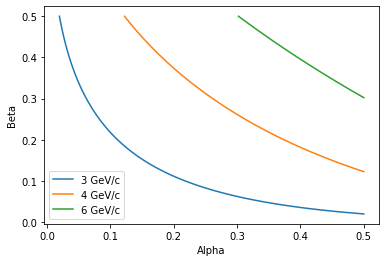

In [242]:
plt.plot(a1[:,0], a1[:,1],label="3 GeV/c")
plt.plot(a2[:,0], a2[:,1],label="4 GeV/c")
plt.plot(a3[:,0], a3[:,1],label="6 GeV/c")
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("Beta")
plt.show()

    The 3 GeV/c momentum run has better performance. The point closest to (0,0) is on the 3 GeV/c curve. For p >> m, we can roughly say that momentum is inversely propertional to time. For fixed mass, the difference between the time taken to traverse the distance by both the particles becomes larger as the momentum goes smaller, so any overlap they might have reduces. 

    Among the studied cases, 3 GeV/c will have the least overlap and hence, at a certain cutoff will have the best parameters of alpha and beta. 

### Problem 3

total # of events = 43.0 # of bins= 50


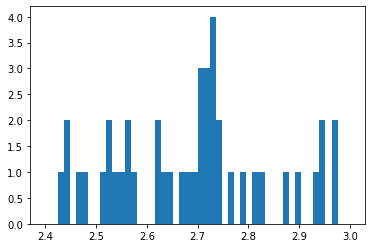

In [243]:
nbins = 50
XMIN = 2.4 # in GeV
XMAX = 3.0 # in GeV
sigma = 0.012
bins = np.linspace(XMIN, XMAX, nbins)
counts = np.array([0, 0, 1, 2, 0, 1, 1, 0, 0, 1, 2, 1, 1, 2, 1, 0, 0, 0, 2, 1, 1,
0, 1, 1, 1, 3, 3, 4, 2, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 2, 0, 2, 0, 0]).astype(float)
tot = 0
for i in counts:
    tot += i
print("total # of events =",tot, "# of bins=",len(counts))
plt.hist(bins, bins=len(counts),weights=counts, range=(min(bins), max(bins))) 
plt.show()

#### 3.1 / a

In [244]:
average_background_events_per_bin = tot/nbins
average_background_events_per_bin

0.86

    The average number of background events per bin : 0.86

#### 3.1 / b

In [245]:
peak_mass = bins[np.argmax(counts)]
peak_mass

2.730612244897959

    Location of the peak in the mass spectrum ~ 2.73 GeV/$c^2$

#### 3.1 / c

In [246]:
width = 2.5*sigma

window_indices = np.where(np.logical_and(bins >= peak_mass - width, bins <= peak_mass + width))[0] # this retursn 5 indices corresponding to 5 bins
Nobs = np.sum(counts[window_indices])
Nobs


12.0

    The total number of events in the required window: 12.0

#### 3.1 / d

In [247]:
Nbgd = average_background_events_per_bin * window_indices.size

Pobs = 1-np.sum(poisson.pmf(np.arange(Nobs),Nbgd))
std = erfinv(1 - Pobs) * np.sqrt(2)

Nbgd,Pobs,std

(4.3, 0.0016660844240050654, 3.144082533933647)

    Nbgd = 4.3 
    p-value ~ 0.002
    and its sigma ~ 3

## 3.2

#### a


In [248]:
class Flat:
    """Generates Linear Class with parameters for linear function.
    """
    def __init__(self,avg_per_bin):
        self.mass = []
        self.avg_per_bin = avg_per_bin
     
      
        
    def evaluate(self):
        """Evaluates linear function at input(inp)

        Args:
            input (float, Numpy Array): Any number that needs to be mapped

        Returns:
            float, Numpy Array: input mapped onto a linear function
        """
        return self.avg_per_bin       
    
class Gaussian:
    """Generates Gaussian Class with parameters for Gaussian function.
    """
    def __init__(self,mean,sigma=sigma):
        self.mass = []
        self.mean = mean
        self.sigma = sigma
        
    def evaluate(self, inp):
        """Evaluates linear function at input(inp)
        Args:
            inp (f): _description_

        Returns:
            _type_: _description_
        """
        return np.exp(-(inp - self.mean)**2 / (2 * self.sigma**2)) # where 1 was amplitude initially
        
                    


#### b

In [249]:
def pdf(y0,mean,F):
    return lambda x: (1-F)*Flat(y0).evaluate() + (F)*Gaussian(mean).evaluate(x)
    

def chisq(y0,mean,F):
    yo = counts
    yo[yo == 0] = 1e-16 # set the 0 values to some small number to prevent error on the log function
    
    yp = pdf(y0,mean,F) 
    n = quad(yp,XMIN,XMAX)[0]
    yp = yp(bins)/n #normalise the pdf
    
    return 2*np.sum( (yp-yo) + yo*np.log(yo/yp))

#### c

**Fixing F = 0, makes it the H0 pdf.** The y0 here represents the variable for average number of background counts per bin.
And mean is fixed so minuit does not vary it but it does not matter as the guassian element does not come into account since F = 0.

Errordef is set to 1.0 as it is minimised using chi-square equivalent.

In [250]:
m_h0 = im(chisq,y0=average_background_events_per_bin,mean=2.4,F=0)
m_h0.fixed['F','mean'] = True 
m_h0.errordef = 1.0
m_h0.migrad()
X2_h0 = chisq(*m_h0.values[0:])

In [251]:
dX2_list = np.empty(nbins)

for i in range(nbins):
    m_h1 = im(chisq,y0=average_background_events_per_bin,mean=bins[i],F=0.0)
    m_h1.fixed['mean'] = True
    m_h1.errordef = 1.0
    
    m_h1.migrad()

    dX2_list[i] = (X2_h0-chisq(*m_h1.values[0:]))



/var/folders/2f/y14hzqx53r56d9npnh5jl95m0000gp/T/ipykernel_2560/2631581261.py:13: RuntimeWarning: invalid value encountered in log
  return 2*np.sum( (yp-yo) + yo*np.log(yo/yp))
/var/folders/2f/y14hzqx53r56d9npnh5jl95m0000gp/T/ipykernel_2560/2631581261.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  n = quad(yp,XMIN,XMAX)[0]


E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.


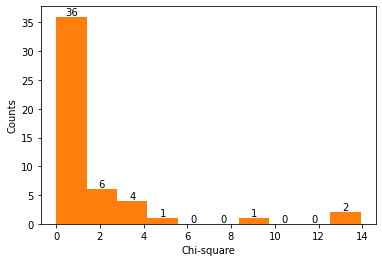

In [252]:
plt.hist(dX2_list)

counts, edges, bars = plt.hist(dX2_list)
plt.xlabel("Chi-square")
plt.ylabel("Counts")
plt.bar_label(bars)
plt.show()

Most of the Chi-square have a relativley small difference, i.e H0 and H1 fit are quite close in their explanation at most of the bins. There are few counts of relatively larger difference in chi square, which are possibly the bins in the window of the peak in the data. The largest difference most likley corresponds to the fitting at the bins containing the peak.

#### d

In [253]:
dX2 = np.amax(dX2_list)
p_value = 1-chi2.cdf(dX2,2)
n_sigma = erfinv(1 - p_value) * np.sqrt(2)

print("NLL/X2 equivalent(rounded to 5 s.f): {:.5f} p-value(rounded to  s.f): {:.5f} and n-sigma: {:.0f}".format(dX2,p_value, n_sigma))

NLL/X2 equivalent(rounded to 5 s.f): 13.92144 p-value(rounded to  s.f): 0.00095 and n-sigma: 3


    χ2 (H0 )−χ2 (H1 ) equivalent(rounded to 5 s.f): 13.92144 
    p-value(rounded to  s.f): 0.00095 
    n-sigma: 3

In about 1000 experiments, we might observe one such chi-square difference by chance because of the background. There is ~ 99.905% chance that the bin with the corresponding chi-square difference contains a signal. The deviation from background is unlikely to be just an anomalous behvaiour of the background.